# Gradient Boosted Trees to Forecast Merchant Monthly Revenue
This notebook will employ the Gradient Boosted Trees model to forecast merchant's monthly revenue to create an overall ranking system.

In [20]:
# Initialise a spark session
import pandas as pd
from collections import Counter
import os
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StandardScaler, StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor



spark = (
    SparkSession.builder.appName("GBT Model")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "16g")  # Increase driver memory
    .config("spark.executor.memory", "16g")  # Increase executor memory
    .config("spark.executor.instances", "4")  # Increase the number of executor instances
    .config("spark.driver.maxResultSize", "2g")
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()
)

24/09/27 16:27:28 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [21]:
# Read transaction file
transactions = spark.read.parquet('../data/curated/flagged_fraud')
transactions = transactions.filter(F.col("is_fraud") != True) # Exclude transactions marked as fraud

In [22]:
# Aggregating monthly revenue for each merchant
monthly_revenue_df = transactions.groupBy('merchant_abn', 'order_month_year').agg(
    F.sum('dollar_value').alias('monthly_revenue'),
    F.count('order_id').alias('transaction_count'),
    F.avg('fraud_probability_merchant').alias('avg_fraud_probability_merchant'),
    F.first('name_merchant').alias('merchant_name'),
    F.avg('take_rate').alias('avg_take_rate'),
    F.first('revenue_band').alias('revenue_band'),
    F.first('merchant_category').alias('merchant_category')
)
    
# Aggregating consumer-level features (most common state and gender for each merchant)

# Most common consumer state per merchant
consumer_state_mode = transactions.groupBy('merchant_abn', 'state_consumer').count() \
    .withColumn('row_num', F.row_number().over(Window.partitionBy('merchant_abn').orderBy(F.desc('count')))) \
    .filter(F.col('row_num') == 1) \
    .select('merchant_abn', 'state_consumer')

# Most common consumer gender per merchant
consumer_gender_mode = transactions.groupBy('merchant_abn', 'gender_consumer').count() \
    .withColumn('row_num', F.row_number().over(Window.partitionBy('merchant_abn').orderBy(F.desc('count')))) \
    .filter(F.col('row_num') == 1) \
    .select('merchant_abn', 'gender_consumer')

# Average Unemployment Rate per Merchant Month-Year
transactions = transactions.withColumn("unemployment_rate_numeric", F.col("unemployment_rate").cast("float"))

unemployment_agg = transactions.groupBy('merchant_abn', 'order_month_year').agg(
    F.avg('unemployment_rate_numeric').alias('avg_unemployment_rate')
)

In [23]:
# Joining Datasets
monthly_revenue_df = monthly_revenue_df.join(consumer_state_mode, on='merchant_abn', how='left') \
                                      .join(consumer_gender_mode, on='merchant_abn', how='left')

# Join with unemployment data on both 'merchant_abn' and 'order_month_year'
monthly_revenue_df = monthly_revenue_df.join(unemployment_agg, on=['merchant_abn', 'order_month_year'], how='left')

# Show the final dataframe
monthly_revenue_df.show(5)

+------------+----------------+------------------+-----------------+------------------------------+--------------------+-------------------+------------+--------------------+--------------+---------------+---------------------+
|merchant_abn|order_month_year|   monthly_revenue|transaction_count|avg_fraud_probability_merchant|       merchant_name|      avg_take_rate|revenue_band|   merchant_category|state_consumer|gender_consumer|avg_unemployment_rate|
+------------+----------------+------------------+-----------------+------------------------------+--------------------+-------------------+------------+--------------------+--------------+---------------+---------------------+
| 10023283211|          Mar-21| 9076.307821688919|               40|             56.40749878739966|       Felis Limited|0.18000000715255737|           e|furniture, home f...|           NSW|           Male|     78.1724992275238|
| 10142254217|          Nov-21|13097.452353073131|              315|             55.4786

In [24]:
# Creating lag features to include previous month's revenue
window_spec = Window.partitionBy('merchant_abn').orderBy('order_month_year')

# Lagging features: Previous month's revenue
monthly_revenue_df = monthly_revenue_df.withColumn(
    'previous_month_revenue', F.lag('monthly_revenue', 1).over(window_spec)
)

# Calculate revenue growth (percentage change)
monthly_revenue_df = monthly_revenue_df.withColumn(
    'revenue_growth',
    F.when(F.col('previous_month_revenue') > 0, 
           (F.col('monthly_revenue') - F.col('previous_month_revenue')) / F.col('previous_month_revenue'))
    .otherwise(F.lit(0))  # Fill with 0 if there is no previous revenue
)

# Fill NA values for first month with 0 (no previous data available)
monthly_revenue_df = monthly_revenue_df.fillna({'previous_month_revenue': 0, 'revenue_growth': 0})


monthly_revenue_df = monthly_revenue_df.fillna(0)  # Filling NA values for first month
monthly_revenue_df.show(5)

+------------+----------------+------------------+-----------------+------------------------------+-------------+-------------------+------------+--------------------+--------------+---------------+---------------------+----------------------+--------------------+
|merchant_abn|order_month_year|   monthly_revenue|transaction_count|avg_fraud_probability_merchant|merchant_name|      avg_take_rate|revenue_band|   merchant_category|state_consumer|gender_consumer|avg_unemployment_rate|previous_month_revenue|      revenue_growth|
+------------+----------------+------------------+-----------------+------------------------------+-------------+-------------------+------------+--------------------+--------------+---------------+---------------------+----------------------+--------------------+
| 10023283211|          Apr-21| 9221.405806871098|               47|             56.03849374950703|Felis Limited|0.18000000715255737|           e|furniture, home f...|           NSW|           Male|    74.

In [25]:
# StringIndexing categorical columns (merchant_tags, consumer_state, gender_consumer)
indexers = [
    StringIndexer(inputCol='state_consumer', outputCol='state_consumer_indexed', handleInvalid='keep'),
    StringIndexer(inputCol='gender_consumer', outputCol='gender_consumer_indexed', handleInvalid='keep'),
    StringIndexer(inputCol='merchant_category', outputCol='category_indexed', handleInvalid='keep'),
    StringIndexer(inputCol='revenue_band', outputCol='revenue_band_indexed', handleInvalid='keep')
]

# OneHotEncoding indexed columns
encoders = [
    OneHotEncoder(inputCol='state_consumer_indexed', outputCol='state_consumer_encoded'),
    OneHotEncoder(inputCol='gender_consumer_indexed', outputCol='gender_consumer_encoded'),
    OneHotEncoder(inputCol='category_indexed', outputCol='category_encoded'),
    OneHotEncoder(inputCol='revenue_band_indexed', outputCol='revenue_band_encoded')
]

feature_cols = [
        'monthly_revenue', 'transaction_count', 'avg_fraud_probability_merchant', 'avg_unemployment_rate',
        'state_consumer_encoded', 'gender_consumer_encoded', 'revenue_growth', 'category_encoded', 'revenue_band_encoded',
        'avg_take_rate'
    ]

# VectorAssembler to combine numeric features into a single feature vector
assembler = VectorAssembler(
    inputCols= feature_cols, 
    outputCol='features'
)

# Standardizing the numeric features
scaler = StandardScaler(inputCol='features', outputCol='scaled_features')

pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler])

# Fit the pipeline to the dataset
model_pipeline = pipeline.fit(monthly_revenue_df)

final_df = model_pipeline.transform(monthly_revenue_df)

final_df.select('merchant_abn', 'order_month_year', 'scaled_features').show(5)

+------------+----------------+--------------------+
|merchant_abn|order_month_year|     scaled_features|
+------------+----------------+--------------------+
| 10023283211|          Apr-21|(145,[0,1,2,3,4,1...|
| 10023283211|          Aug-21|(145,[0,1,2,3,4,1...|
| 10023283211|          Dec-21|(145,[0,1,2,3,4,1...|
| 10023283211|          Feb-22|(145,[0,1,2,3,4,1...|
| 10023283211|          Jan-22|(145,[0,1,2,3,4,1...|
+------------+----------------+--------------------+
only showing top 5 rows



In [26]:
train_data, test_data = final_df.randomSplit([0.8, 0.2], seed=42)

In [27]:
# Define the GBT Regressor
gbt = GBTRegressor(featuresCol='scaled_features', labelCol='monthly_revenue')

# Fit the model on the training data
gbt_model = gbt.fit(train_data)

# Make predictions on the test data
gbt_predictions = gbt_model.transform(test_data)

In [28]:
# Evaluate the model
evaluator = RegressionEvaluator(labelCol='monthly_revenue', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(gbt_predictions)
print(f"RMSE (GBT): {rmse}")

RMSE (GBT): 52731.87085900513


In [29]:
r2_evaluator = RegressionEvaluator(labelCol='monthly_revenue', predictionCol='prediction', metricName='r2')
r2 = r2_evaluator.evaluate(gbt_predictions)
print(f"R-squared: {r2}")

R-squared: 0.7400655458450198


In [30]:
from pyspark.sql.types import DateType
from dateutil.relativedelta import relativedelta
from datetime import datetime

# Step 1: Parse the order_month_year column to a proper date format
monthly_revenue_df = monthly_revenue_df.withColumn(
    'order_month_year_date', F.to_date(F.concat(F.lit('01-'), F.col('order_month_year')), 'dd-MMM-yy')
)

# Get the most recent month per merchant
window_spec = Window.partitionBy('merchant_abn').orderBy(F.desc('order_month_year_date'))
latest_merchant_data = monthly_revenue_df.withColumn('row_num', F.row_number().over(window_spec)) \
                                         .filter(F.col('row_num') == 1) \
                                         .drop('row_num')

In [31]:
next_month = 'Aug-24'
future_month_df = spark.createDataFrame([(next_month,)], ['future_order_month_year'])
future_data = latest_merchant_data.crossJoin(future_month_df)

In [32]:
future_data.show(5)

+------------+----------------+-----------------+-----------------+------------------------------+--------------------+-------------------+------------+--------------------+--------------+---------------+---------------------+----------------------+--------------------+---------------------+-----------------------+
|merchant_abn|order_month_year|  monthly_revenue|transaction_count|avg_fraud_probability_merchant|       merchant_name|      avg_take_rate|revenue_band|   merchant_category|state_consumer|gender_consumer|avg_unemployment_rate|previous_month_revenue|      revenue_growth|order_month_year_date|future_order_month_year|
+------------+----------------+-----------------+-----------------+------------------------------+--------------------+-------------------+------------+--------------------+--------------+---------------+---------------------+----------------------+--------------------+---------------------+-----------------------+
| 10023283211|          Feb-22|48572.88260819351|

In [33]:
future_data = model_pipeline.transform(future_data)
future_data = gbt_model.transform(future_data)

In [34]:
future_predictions = future_data.select('merchant_abn', 'merchant_name', 'merchant_category','future_order_month_year', 'prediction')
future_predictions = future_predictions.withColumnRenamed('prediction', 'projected_revenue')
future_predictions.show(5)

+------------+--------------------+--------------------+-----------------------+------------------+
|merchant_abn|       merchant_name|   merchant_category|future_order_month_year| projected_revenue|
+------------+--------------------+--------------------+-----------------------+------------------+
| 10023283211|       Felis Limited|furniture, home f...|                 Aug-24| 56342.26277063221|
| 10142254217|Arcu Ac Orci Corp...|cable, satellite,...|                 Aug-24| 7938.103752542175|
| 10187291046|Ultricies Digniss...|watch, clock, and...|                 Aug-24| 3752.461085817395|
| 10192359162| Enim Condimentum PC|music shops - mus...|                 Aug-24|11587.997680903285|
| 10206519221|       Fusce Company|gift, card, novel...|                 Aug-24|  7830.16740425137|
+------------+--------------------+--------------------+-----------------------+------------------+
only showing top 5 rows



In [35]:
GBT_predictions = future_predictions.orderBy(F.col('projected_revenue').desc())

# Show the top 10 merchants by predicted revenue
GBT_predictions.show(10)

+------------+--------------------+--------------------+-----------------------+------------------+
|merchant_abn|       merchant_name|   merchant_category|future_order_month_year| projected_revenue|
+------------+--------------------+--------------------+-----------------------+------------------+
| 76626119831|Tristique Pellent...|antique shops - s...|                 Aug-24|1090304.1654838412|
| 80518954462|Neque Sed Dictum ...|computers, comput...|                 Aug-24| 766849.9222552462|
| 35909341340|Arcu Sed Eu Incor...|computer programm...|                 Aug-24| 698964.4635210154|
| 77590625261| Sed Diam Foundation|computer programm...|                 Aug-24| 695996.5497646653|
| 90543168331|Phasellus Dapibus...|furniture, home f...|                 Aug-24| 618464.6391918396|
| 48534649627|Dignissim Maecena...|opticians, optica...|                 Aug-24|  605325.974392107|
| 21772962346|Purus Gravida Sag...|florists supplies...|                 Aug-24| 596550.8925803514|


## Evaluating Model

In [36]:
importances = gbt_model.featureImportances
importance_values = importances.toArray()

In [37]:
# Fit the StringIndexer on your data
indexers = [
    StringIndexer(inputCol='state_consumer', outputCol='state_consumer_indexed', handleInvalid='keep'),
    StringIndexer(inputCol='gender_consumer', outputCol='gender_consumer_indexed', handleInvalid='keep'),
    StringIndexer(inputCol='merchant_category', outputCol='category_indexed', handleInvalid='keep'),
    StringIndexer(inputCol='revenue_band', outputCol='revenue_band_indexed', handleInvalid='keep')
]

indexer_models = [indexer.fit(monthly_revenue_df) for indexer in indexers]

# Get the actual number of categories for each categorical column
for indexer_model in indexer_models:
    print(f"Column: {indexer_model.getInputCol()} - Number of Categories: {len(indexer_model.labels)}")

Column: state_consumer - Number of Categories: 7
Column: gender_consumer - Number of Categories: 3
Column: merchant_category - Number of Categories: 124
Column: revenue_band - Number of Categories: 5


In [38]:
vec_assembler_stage = model_pipeline.stages[-2]
encoded_feature_cols = vec_assembler_stage.getInputCols()

onehot_encoded_sizes = {
    'state_consumer_encoded': 7,  # Update with the actual number of categories
    'gender_consumer_encoded': 3,  # Update with the actual number of categories
    'category_encoded': 124,  # Update with actual number
    'revenue_band_encoded':5  # Update with actual number
}

# Flatten the encoded features (e.g., one-hot encoded columns)
expanded_feature_cols = []
for col in encoded_feature_cols:
    if col in onehot_encoded_sizes:
        expanded_feature_cols.extend([f'{col}_{i}' for i in range(onehot_encoded_sizes[col])])
    else:
        expanded_feature_cols.append(col)

In [39]:
feature_importance_df = pd.DataFrame({
    'Feature': expanded_feature_cols,
    'Importance': importance_values
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

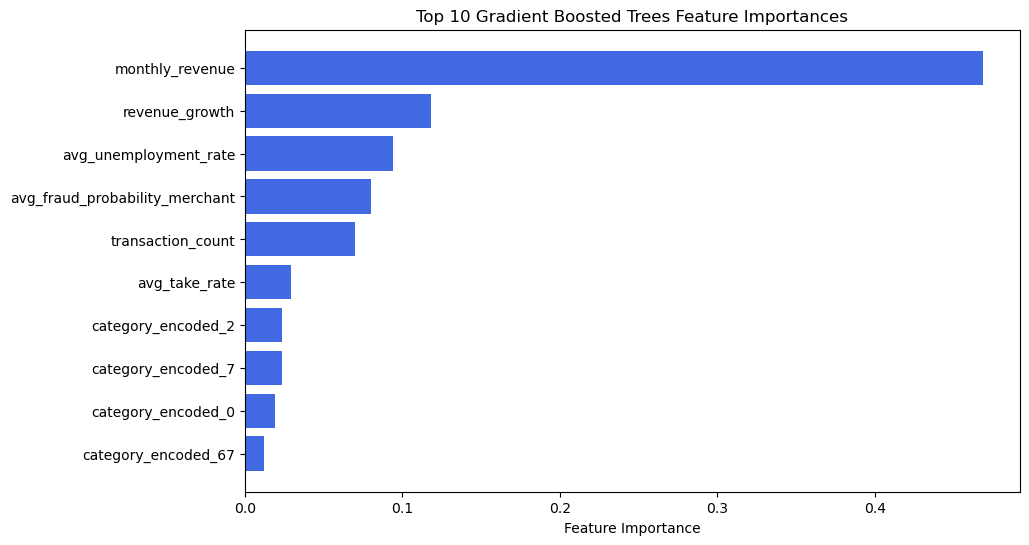

In [40]:
import matplotlib.pyplot as plt

# Sort the features by importance and take the top 10
top_10_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='royalblue')
plt.xlabel('Feature Importance')
plt.title('Top 10 Gradient Boosted Trees Feature Importances')
plt.gca().invert_yaxis()
plt.show()

In [41]:
# Explore which category is referred to in feature importance
category_indexer_model = indexer_models[2]

# Get the list of categories
category_labels = category_indexer_model.labels

print(f"Category for category_encoded_2: {category_labels[2]}")
print(f"Category for category_encoded_7: {category_labels[7]}")
print(f"Category for category_encoded_0: {category_labels[0]}")
print(f"Category for category_encoded_67: {category_labels[67]}")

Category for category_encoded_2: gift, card, novelty, and souvenir shops
Category for category_encoded_7: cable, satellite, and other pay television and radio services
Category for category_encoded_0: tent and awning shops
Category for category_encoded_67: furniture, home furnishings and equipment shops, and manufacturers,  except appliances


## Export Final Ranking of Top 100 Merchants

In [17]:
GBT_predictions = GBT_predictions.limit(100)
GBT_predictions.write.parquet('../data/curated/GBT_ranking')

In [18]:
spark.stop()